In [7]:
# ==========================================================
# BELT AND ROAD INITIATIVE ONLINE NEWS SENTIMENT ANALYSIS
# (Bangladesh Case) - PDF + OCR Version (TextBlob + NLTK)
# ==========================================================

!apt-get install poppler-utils tesseract-ocr -y
!pip install textblob nltk pandas matplotlib tqdm PyPDF2 pdf2image pytesseract

from textblob import TextBlob
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import io
import zipfile
import os
import re
from google.colab import files
import PyPDF2
from pdf2image import convert_from_path
import pytesseract
from pytesseract import Output

nltk.download('punkt')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# --- Step 1: Upload files ---
print("👉 Upload either a ZIP file containing your PDF articles OR individual .pdf files:")
uploaded = files.upload()

upload_folder = "uploaded_pdfs"
os.makedirs(upload_folder, exist_ok=True)

# --- Step 2: Handle uploaded content ---
for filename in uploaded.keys():
    if filename.endswith(".zip"):
        with zipfile.ZipFile(io.BytesIO(uploaded[filename]), 'r') as zip_ref:
            zip_ref.extractall(upload_folder)
        print("✅ ZIP extracted successfully!")
    elif filename.endswith(".pdf"):
        with open(os.path.join(upload_folder, filename), "wb") as f:
            f.write(uploaded[filename])
        print(f"✅ Saved: {filename}")

pdf_files = [f for f in os.listdir(upload_folder) if f.endswith(".pdf")]
if not pdf_files:
    raise FileNotFoundError("No PDF files found. Please upload .pdf files or a ZIP containing them.")


👉 Upload either a ZIP file containing your PDF articles OR individual .pdf files:


Saving _Bangladesh not ready for the new game of engagement_.pdf to _Bangladesh not ready for the new game of engagement_ (6).pdf
Saving _BRI is a mega plan with deep geostrategic and geoeconomic consequences_.pdf to _BRI is a mega plan with deep geostrategic and geoeconomic consequences_ (6).pdf
Saving _China-Bangladesh relations have become the model of friendship between countries with different social systems and different cultures_ _ The Daily Star.pdf to _China-Bangladesh relations have become the model of friendship between countries with different social systems and different cultures_ _ The Daily Star (6).pdf
Saving ‘Bangladesh can’t wait forever to resolve the Teesta issue’ _ The Daily Star.pdf to ‘Bangladesh can’t wait forever to resolve the Teesta issue’ _ The Daily Star (6).pdf
Saving ‘Belt and Road Initiative’ to create partnership linkages_ Roundtable _ The Financial Express.pdf to ‘Belt and Road Initiative’ to create partnership linkages_ Roundtable _ The Financial Expr

In [9]:
# --- Step 3: Functions for text extraction ---
def extract_text_from_pdf(pdf_path):
    """Extract text from text-based PDFs"""
    text = ""
    try:
        with open(pdf_path, "rb") as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
                extracted = page.extract_text() or ""
                text += extracted
    except Exception as e:
        print(f"⚠️ Error reading {pdf_path}: {e}")
    return text.strip()

def ocr_pdf(pdf_path):
    """Extract text from scanned/image-based PDFs using OCR"""
    text = ""
    try:
        images = convert_from_path(pdf_path)
        for image in images:
            ocr_text = pytesseract.image_to_string(image, lang="eng", config="--psm 6")
            text += ocr_text + "\n"
    except Exception as e:
        print(f"⚠️ OCR failed for {pdf_path}: {e}")
    return text.strip()

In [10]:
# --- Step 4: Extract text and sentiment ---
data = []
for file in tqdm(pdf_files):
    path = os.path.join(upload_folder, file)

    # Try normal extraction
    text = extract_text_from_pdf(path)

    # If no text found, use OCR
    if not text.strip():
        print(f"🟠 Using OCR for: {file}")
        text = ocr_pdf(path)

    # Skip completely unreadable files
    if not text.strip():
        print(f"❌ Skipping unreadable file: {file}")
        continue

    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    data.append({
        "filename": file,
        "text": text,
        "polarity": polarity,
        "subjectivity": subjectivity
    })

df = pd.DataFrame(data)
if df.empty:
    raise ValueError("⚠️ No readable text found in any PDFs.")

print(f"\n✅ Successfully processed {len(df)} PDFs.")


100%|██████████| 357/357 [01:41<00:00,  3.53it/s]


✅ Successfully processed 357 PDFs.


In [12]:
# --- Step 5: Extract date from filename ---
def extract_date(fname):
    match = re.search(r'\d{4}[-_]\d{2}[-_]\d{2}', fname)
    if match:
        date_str = match.group(0).replace("_", "-")
        try:
            return pd.to_datetime(date_str)
        except:
            return None
    return None

df["date"] = df["filename"].apply(extract_date)

In [13]:
# --- Step 6: Label sentiments ---
def sentiment_label(score):
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_label"] = df["polarity"].apply(sentiment_label)


In [14]:
# --- Step 7: Handle dates safely ---
if df["date"].isna().all():
    print("⚠️ No valid dates found in filenames. Skipping time-series plot.")
else:
    df = df.dropna(subset=["date"]).sort_values("date")

⚠️ No valid dates found in filenames. Skipping time-series plot.


In [15]:
# --- Step 8: Sentiment Trend (if date exists) ---
if "date" in df.columns and df["date"].notna().any():
    sentiment_over_time = df.groupby("date")["polarity"].mean().reset_index()
    plt.figure(figsize=(12,6))
    plt.plot(sentiment_over_time["date"], sentiment_over_time["polarity"], marker='o', linewidth=2)
    plt.title("Sentiment Trend Over Time - Belt and Road Initiative (Bangladesh)")
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment (Polarity)")
    plt.grid(True)
    plt.show()
else:
    print("⏭️ Skipping time-series plot (no valid dates found).")


⏭️ Skipping time-series plot (no valid dates found).


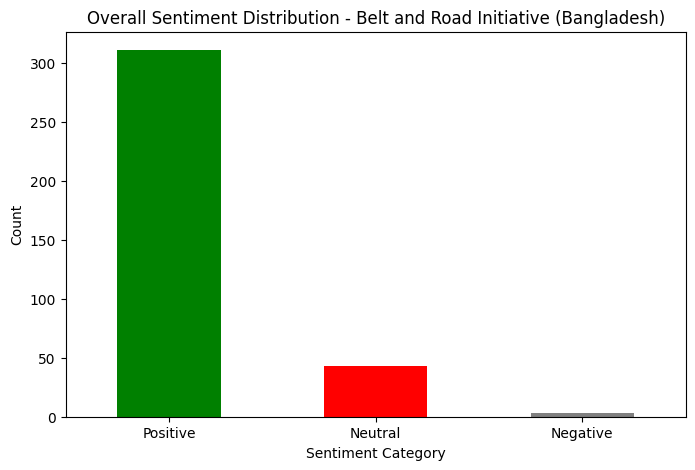

In [16]:
# --- Step 9: Bar Plot of Sentiment Distribution ---
plt.figure(figsize=(8,5))
df["sentiment_label"].value_counts().plot(
    kind="bar",
    color=["green", "red", "gray"][:df["sentiment_label"].nunique()]
)
plt.title("Overall Sentiment Distribution - Belt and Road Initiative (Bangladesh)")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [17]:
# --- Step 10: Export results ---
df.to_csv("bri_pdf_sentiment_results_ocr.csv", index=False)
files.download("bri_pdf_sentiment_results_ocr.csv")
print("✅ Exported sentiment results with OCR to CSV successfully!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Exported sentiment results with OCR to CSV successfully!
